In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,silhouette_score 
from sklearn.cluster import KMeans
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
#read train image with CV
root_dir = '/data/fjsdata/ECG/PVC/MIT-BIH-MLII/' #the path of images
trN, trI, trY = [],[],[]
for iname in os.listdir(root_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(root_dir, iname)
            isub = int(os.path.splitext(iname)[0].split("-")[0])
            itype = int(os.path.splitext(iname)[0].split("-")[2])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trN.append(isub)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),6902))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))

6902 / 6902 The length of train set is 6902


In [10]:
#ATH model with cross entropy loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, class_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        out = self.linear(x)
        return x,out

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define model
model = ATHNet(class_size=3).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        _, out_batch = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
trY_pred = []
trF = [] 
num_batches = len(trY) // batchSize  +1 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    feature,out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(feature.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    trY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(trY, trY_pred))
labels = list(set(trY))
cm = confusion_matrix(trY, trY_pred, labels=labels ) 
print (cm)
print ('Accuracy of PVC0: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Accuracy of PVC1: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Accuracy of PVC2: %.6f'%float(cm[2][2]/np.sum(cm[2])))

 691 / 691 : loss = 0.004958Eopch:     1 mean_loss = 0.146913
 691 / 691 : loss = 0.000692Eopch:     2 mean_loss = 0.086103
 691 / 691 : loss = 6.9e-056Eopch:     3 mean_loss = 0.069500
 691 / 691 : loss = 1.9e-057Eopch:     4 mean_loss = 0.060856
 691 / 691 : loss = 0.009689Eopch:     5 mean_loss = 0.056869
 691 / 691 : loss = 5.1e-054Eopch:     6 mean_loss = 0.051158
 691 / 691 : loss = 0.002036Eopch:     7 mean_loss = 0.045746
 691 / 691 : loss = 0.009823Eopch:     8 mean_loss = 0.039389
 691 / 691 : loss = 0.077883Eopch:     9 mean_loss = 0.034326
 691 / 691 : loss = 0.000319Eopch:    10 mean_loss = 0.031337
best_loss = 0.031337
 690 / 691 Accuracy: 0.992901
[[ 642    0   34]
 [   0 3024    5]
 [   9    1 3187]]
Accuracy of PVC2: 0.949704
Accuracy of PVC3: 0.998349
Accuracy of PVC1: 0.996872


Org data dimension is 1024.Embedded data dimension is 2


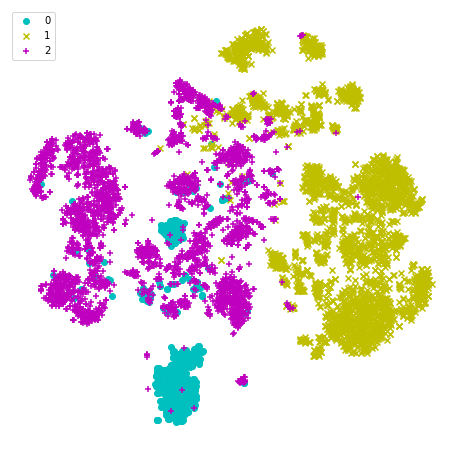

In [12]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=3
idx= np.where(np.array(trY)==0)[0].tolist()
X0= np.array(trF)[idx]
y0= np.array(trY)[idx]

idx= np.where(np.array(trY)==1)[0].tolist()
X1= np.array(trF)[idx]
y1= np.array(trY)[idx]

idx= np.where(np.array(trY)==2)[0].tolist()
X2= np.array(trF)[idx]
y2= np.array(trY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [20]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'dense' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0: 'PVC0', 1: 'PVC1', 2:'PVC2'}
#read image
root=root_dir+'228-5955-0.png'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('pvc_cam.jpg', result)

0.740 -> PVC0
0.260 -> PVC2
0.000 -> PVC1
output CAM.jpg for the top1 prediction: PVC0


True